# Cat and Dog Classification
Classify images of cats and dogs using Histogram of Oriented Gradients (HOG) for feature extraction and Decision Tree for classification.

In [1]:
import os
import numpy as np
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import hog
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
# Load dataset
data_dir = './dataset'
images, labels = [], []

for file in os.listdir(data_dir):
    if file.endswith('.jpg'):
        img_path = os.path.join(data_dir, file)

        if file.startswith('cat'):
            labels.append(0)  # Cat
        elif file.startswith('dog'):
            labels.append(1)  # Dog
        else:
            continue

        img = imread(img_path)
        img = rgb2gray(img)  # Convert to grayscale
        img_resized = resize(img, (128, 128), anti_aliasing=True)
        images.append(img_resized)

images = np.array(images)
labels = np.array(labels)
print('Images shape:', images.shape)
print('Labels shape:', labels.shape)
print(f'Number of cats: {np.sum(labels == 0)}')
print(f'Number of dogs: {np.sum(labels == 1)}')

In [ ]:
def extract_hog_features(images, visualize=False):
    """Extract HOG features from a list of grayscale images.

    Args:
        images: Array of grayscale images (N, 128, 128).
        visualize: If True, return HOG visualizations.

    Returns:
        hog_features: Array of HOG features (N, feature_size).
        hog_images: Array of HOG visualizations (N, 128, 128) if visualize=True, else None.
    """
    hog_features = []
    hog_images_list = [] if visualize else None
    orientations = 9
    pixels_per_cell = (8, 8)
    cells_per_block = (2, 2)
    for img in images:
        if visualize:
            features, hog_image = hog(img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=True, feature_vector=True)
            hog_images_list.append(hog_image)
        else:
            features = hog( img, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, visualize=False, feature_vector=True)

        hog_features.append(features)
    hog_features = np.array(hog_features)
    if visualize:
        hog_images_list = np.array(hog_images_list)
    return hog_features, hog_images_list if visualize else None

In [ ]:
def split_and_save_dataset(images, labels, test_size=0.2, train_dir='./dog-cat/train', test_dir='./dog-cat/test'):
    """Split dataset into training and test sets and save images to separate directories.

    Args:
        images: Array of grayscale images (N, 128, 128).
        labels: Array of labels (0 for cat, 1 for dog).
        test_size: Fraction of data for test set.
        train_dir: Directory to save training images.
        test_dir: Directory to save test images.

    Returns:
        X_train, X_test: HOG features for training and test sets.
        y_train, y_test: Labels for training and test sets.
        idx_train, idx_test: Indices for training and test sets.
    """
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    indices = np.arange(len(images))
    idx_train, idx_test, y_train, y_test = train_test_split(indices, labels, test_size=test_size, random_state=42, stratify=labels)
    for i, idx in enumerate(idx_train):
        label = 'cat' if y_train[i] == 0 else 'dog'
        img_path = os.path.join(train_dir, f'{label}_{i}.png')
        plt.imsave(img_path, images[idx], cmap='gray')
    for i, idx in enumerate(idx_test):
        label = 'cat' if y_test[i] == 0 else 'dog'
        img_path = os.path.join(test_dir, f'{label}_{i}.png')
        plt.imsave(img_path, images[idx], cmap='gray')
    X_train, _ = extract_hog_features(images[idx_train], visualize=False)
    X_test, _ = extract_hog_features(images[idx_test], visualize=False)
    return X_train, X_test, y_train, y_test, idx_train, idx_test

In [ ]:
def train_decision_tree(X_train, y_train):
    """Train a Decision Tree classifier on HOG features.

    Args:
        X_train: HOG features for training (N_train, feature_size).
        y_train: Training labels (0 for cat, 1 for dog).

    Returns:
        clf: Trained Decision Tree classifier.
    """
    clf = DecisionTreeClassifier(random_state=42, max_depth=10, min_samples_split=5)
    clf.fit(X_train, y_train)
    return clf

In [ ]:
def evaluate_model(clf, X_test, y_test):
    """Evaluate the Decision Tree classifier on the test set.

    Args:
        clf: Trained Decision Tree classifier.
        X_test: HOG features for test set (N_test, feature_size).
        y_test: Test labels (0 for cat, 1 for dog).

    Returns:
        accuracy: Test set accuracy.
        y_pred: Predicted labels for test set.
    """
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy, y_pred

Test Accuracy: 0.7407


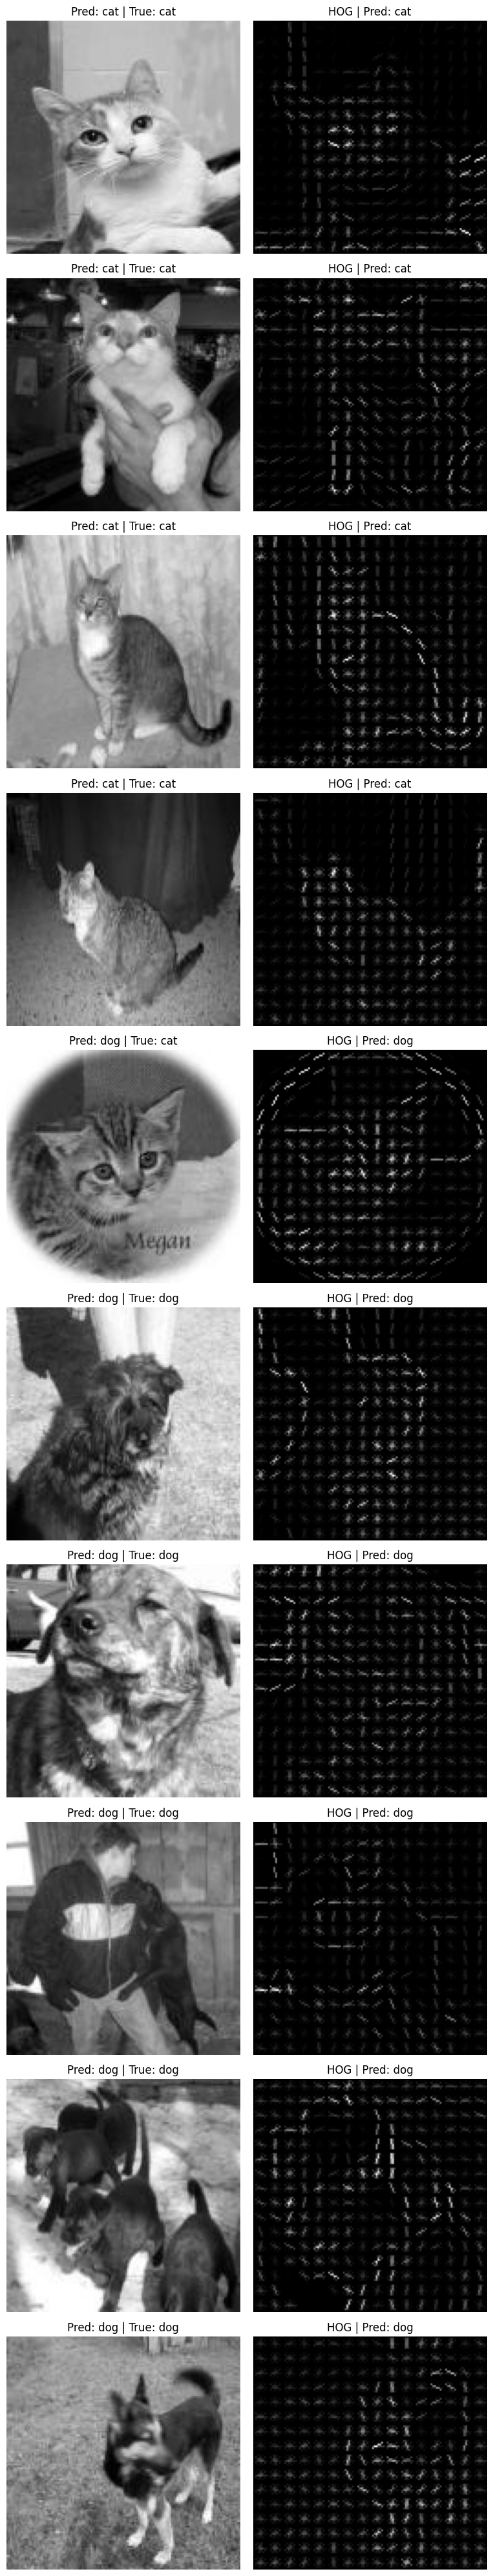

In [ ]:
# Extract HOG features
hog_features, hog_images = extract_hog_features(images, visualize=True)

# Split and save dataset
X_train, X_test, y_train, y_test, idx_train, idx_test = split_and_save_dataset(images, labels, test_size=0.2)

# Train Decision Tree
clf = train_decision_tree(X_train, y_train)

# Evaluate model
accuracy, y_pred = evaluate_model(clf, X_test, y_test)
print(f'Test Accuracy: {accuracy:.4f}')

# Visualize results
classes = ['cat', 'dog']
cat_indices = [idx for idx in idx_test if y_test[np.where(idx_test == idx)[0][0]] == 0]
dog_indices = [idx for idx in idx_test if y_test[np.where(idx_test == idx)[0][0]] == 1]
sample_indices = cat_indices[:min(5, len(cat_indices))] + dog_indices[:min(5, len(dog_indices))]

fig, axes = plt.subplots(len(sample_indices), 2, figsize=(8, 4 * len(sample_indices)))
for i, idx in enumerate(sample_indices):
    ax = axes[i, 0] if len(sample_indices) > 1 else axes[0]
    true_label = y_test[np.where(idx_test == idx)[0][0]]
    pred_label = y_pred[np.where(idx_test == idx)[0][0]]
    ax.imshow(images[idx], cmap='gray')
    ax.set_title(f'Pred: {classes[pred_label]} | True: {classes[true_label]}')
    ax.axis('off')

    ax = axes[i, 1] if len(sample_indices) > 1 else axes[1]
    ax.imshow(hog_images[idx], cmap='gray')
    ax.set_title(f'HOG | Pred: {classes[pred_label]}')
    ax.axis('off')

plt.tight_layout()
plt.show()